#### Author
**Name:** Andres Figueroa  
**Email:** andresfigueroa@brandeis.edu  

#### Project Description
The goal of this project is to build a model that predicts whether a Pokémon is Legendary based on its stats and other features.

---

### Importing Libraries

In [154]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

---
### Step 1: Loading and Exploring the Dataset

In [95]:
df = pd.read_csv('pokemon.csv')

print(df.columns)
print(df.head())

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')
                     abilities  against_bug  against_dark  against_dragon  \
0  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
1  ['Overgrow', 'Chlorophyll']          1.0           1.0             1.0   
2  ['Overgrow', 'Chlorophyll']          1.0         

In [96]:
df.dtypes

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

---

### Step 2: Defining Our ML Problem

### Dataset Explanation

The dataset includes detailed information on all **802 Pokémon** spanning across **seven generations**. It captures a wide variety of attributes such as:

- Base Stats (`hp`, `attack`, `defense`, `sp_attack`, `sp_defense`, `speed`, `total`)
- Pokémon Types
- Abilities
- Height & Weight
- Egg Steps
- Capture Rate
- Experience Growth

These rich and diverse features make the dataset ideal for training a classification model to distinguish Legendary Pokémon from others.

---

### Prediction Target (Label)

The label we are predicting is: **`is_legendary`**

This is a **binary classification** target:
- `1` → Pokémon is Legendary  
- `0` → Pokémon is not Legendary

---

### Problem Type

This is a **supervised learning** problem because the model is trained on labeled examples where the target (`is_legendary`) is known.

Specifically, it is a:
- **Binary Classification** task  
- The goal is to classify each Pokémon as either **Legendary** or **Non-Legendary**

---

### Importance

While this project originated from personal interest—having grown up as a fan of Pokémon—it has practical implications:

- **Game developers** can use models like this to support **game balancing**
- **Content creators** can better understand or generate content focused on **powerful or rare Pokémon**
- **Gaming companies** may leverage these insights to **enhance user engagement**, improve in-game mechanics, or personalize content recommendations


### Step 3: Understanding Our Data

##### Missing Data

In [97]:
df.isnull().sum()[df.isnull().sum() > 0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

> **Note:** While height and weight are numeric, they were dropped due to a lack of correlation with legendary pokemon. Legendary pokemon come in all sorts of shapes and sizes.

#### Visualizing Potential Outliers

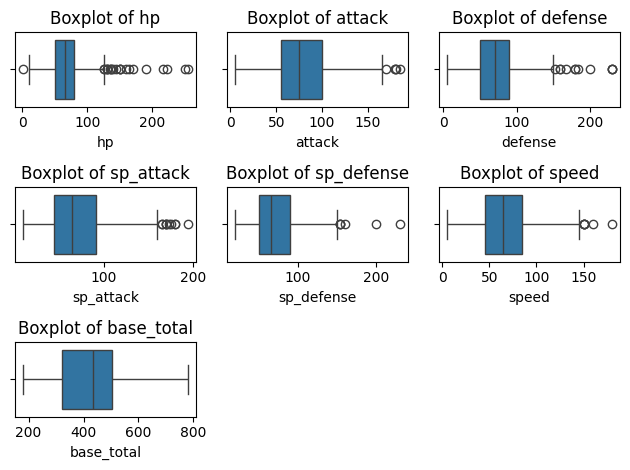

In [98]:
outlier_features = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total']

for i, feature in enumerate(outlier_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

### Note on Outlier Analysis & Considerations

> The following boxplots visualize distributions for key numerical features (`hp`, `attack`, `defense`, `sp_attack`, `sp_defense`, `speed`, and `base_total`). Across all features, we observe several high-end outliers.

While these may initially seem like candidates for removal, I chose to keep them. I made this decision because of the existence of **pseudo-legendary Pokémon**—non-legendary Pokémon with high base stats (600), such as **Dragonite**, **Garchomp**, and **Hydreigon**.

Although not classified as Legendary, these 'outliers' allows the model to learn complex patterns that differentiate true legendary Pokémon from similarly strong counterparts. This goes to show the variance in stats of different pokemon.


#### Getting a Better Understanding of is_legendary (Our Label)

In [99]:
df["is_legendary"]

0      0
1      0
2      0
3      0
4      0
      ..
796    1
797    1
798    1
799    1
800    1
Name: is_legendary, Length: 801, dtype: int64

> **Note:** This is great. The label is already encoded and can be used by the model.

In [100]:
df["is_legendary"].value_counts()

is_legendary
0    731
1     70
Name: count, dtype: int64

> **Note:** There's a significant class imbalances between legendary and non-legendary pokemon. This is important to note because models will be bias and lean towards predicting the majority class (non-legendary). We can use resampling techniques (like SMOTE), or use class weights.

#### Feature Engineering

In [101]:
#print(df.dtypes)
df['capture_rate'] = pd.to_numeric(df['capture_rate'], errors='coerce')
df['capture_rate'].dtype


dtype('float64')

> **Note:** I saw that 'capture_rate' wasn't a numerical value, but rather a string. So, I converted it to a numerical value think it would prove as a valuable feature.

#### Dropping Features

In [102]:
to_drop = ['abilities', 'name', 'percentage_male', 'pokedex_number', 
           'generation', 'type1', 'type2', 'japanese_name', 'base_egg_steps',
           'classfication', 'height_m', 'weight_kg',
           'base_total', 'capture_rate' # Maybe causing data leakage
           ] # Some features that I think are irrelevant to the problem
df = df.drop(columns = to_drop, errors = 'ignore')

to_keep = []
for col in df.columns: # Because I don't want to copy and paste all the weaknesses
    if 'against' not in col: # I want to get rid of all features with 'against' because their weakness tell us nothing about whether they are legendary or not
        to_keep.append(col)

df = df[to_keep]
#print(df.dtypes)
df = df.dropna()

df.columns

Index(['attack', 'base_happiness', 'defense', 'experience_growth', 'hp',
       'sp_attack', 'sp_defense', 'speed', 'is_legendary'],
      dtype='object')

#### Note on Feature Removal

Features removed:
- `height_m`, `weight_kg`: Size doesn't correlate with legendary status.
- `type1`, `type2`: Legendary pokemon can have any type.
- `percentage_male`: Some Pokémon are genderless.
- `base_egg_steps`: Can cause data leakage.
- `capture_rate`: Converted from string but later dropped due to leakage.
- `base_total`: Viewed feature importance and cross-validated discovered it was leaking data.

#### Model Selection

Since this is a **binary classification** task, I selected a diverse set of models to compare:

- **Logistic Regression**: A strong baseline for binary classification tasks.
- **Random Forest Classifier**: Handles feature interactions and non-linearities well.
- **XGBoost**: A powerful gradient boosting method known for its high performance.

---

#### Handling Class Imbalance

The dataset has a **significant class imbalance**, with far fewer Legendary Pokémon than Non-Legendary. To address this, I applied **SMOTE** (Synthetic Minority Over-sampling Technique) on the training set.

This technique generates synthetic examples of the minority class to help the model learn from underrepresented examples and reduce bias.

---

#### Evaluation Metrics

I used the following metrics to evaluation of model performance:

- **Accuracy**: Measures overall correctness of predictions.
- **Precision**: Of all predicted Legendaries, how many were actually Legendary.
- **Recall**: Of all actual Legendaries, how many were correctly predicted.
- **F1 Score**: Harmonic mean of Precision and Recall; useful for imbalanced datasets.
- **ROC AUC Score**: Captures how well the model separates the two classes across all thresholds.

---


### Step 4: Defining The Project Plan

### Feature Selection

The features selected for modeling are primarily **numerical stats**, including:

- `attack`
- `base_happiness`
- `defense`
- `experience_growth`
- `hp`
- `sp_attack`
- `sp_defense`
- `speed`

These features are closely tied to a Pokémon’s **strength and performance**, which may be indicative of whether it is classified as a **Legendary Pokemon**.

---

### Features Removed

Certain features were removed due to low predictive value or redundancy:

- **`type1` and `type2`**: Pokémon types vary even among legendary pokemon.
- **`height_m` and `weight_kg`**: Legendary pokémon also come in different shapes and sizes .
- **Identifiers** like `name`, `japanese_name`, and similar non-numeric fields were removed as they do not contribute to the model's predictive capabilities.
- **`base_total`**: This feature was later discovered to have been leaking data.
- **`capture_rate`**: This feature was later discovered to have been leaking data.

---

### ⚙️ Model Selection

The following models were explored:

- **Logistic Regression**: Serves as a baseline for binary classification.
- **Random Forest Classifier**: Capable of handling feature interactions and robust to overfitting.
- **XGBoost**: A powerful gradient boosting algorithm well-suited for tabular data and binary classification tasks.

---

### 📏 Evaluation Strategy

To comprehensively assess model performance, I focused on:

- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **ROC AUC Score**

Rather than relying solely on accuracy, these metrics provide a better view of how well the model distinguishes between **Legendary** and **Non-Legendary** Pokémon—especially important for imbalanced classification.

Hyperparameter tuning was performed using **GridSearchCV** and/or **RandomizedSearchCV** to further optimize model performance.

---


### Step 5: Implementing Our Project Plan

In [103]:
y = df['is_legendary']
X = df.drop(columns = 'is_legendary')

##### Splitting the Data

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify = y)

##### Feature Scaling

In [105]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

##### Addressing Class Imbalance with SMOTE

In [106]:
smote = SMOTE(random_state = 1234)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

##### Training a Logistic Regression Model

In [107]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train_smote, y_train_smote)
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       147
           1       0.72      0.93      0.81        14

    accuracy                           0.96       161
   macro avg       0.86      0.95      0.90       161
weighted avg       0.97      0.96      0.96       161

ROC AUC: 0.9310009718172984


> **Note:** On the first go, I only used the model’s predictions (`y_pred`) to check how well it worked. This was fine for most metrics like accuracy and F1 score. But for **ROC AUC**, we need the model’s **confidence** (how sure it is about its predictions), not just the final yes/no answer. So I fixed it by using `predict_proba()` to get the probability of a pokemon being legendary. This gives a more accurate ROC AUC score.


#### Training a Random Forest Model

In [119]:
rf = RandomForestClassifier(random_state = 1234)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       147
           1       1.00      0.64      0.78        14

    accuracy                           0.97       161
   macro avg       0.98      0.82      0.88       161
weighted avg       0.97      0.97      0.97       161

ROC AUC (RF): 0.9946550048590865


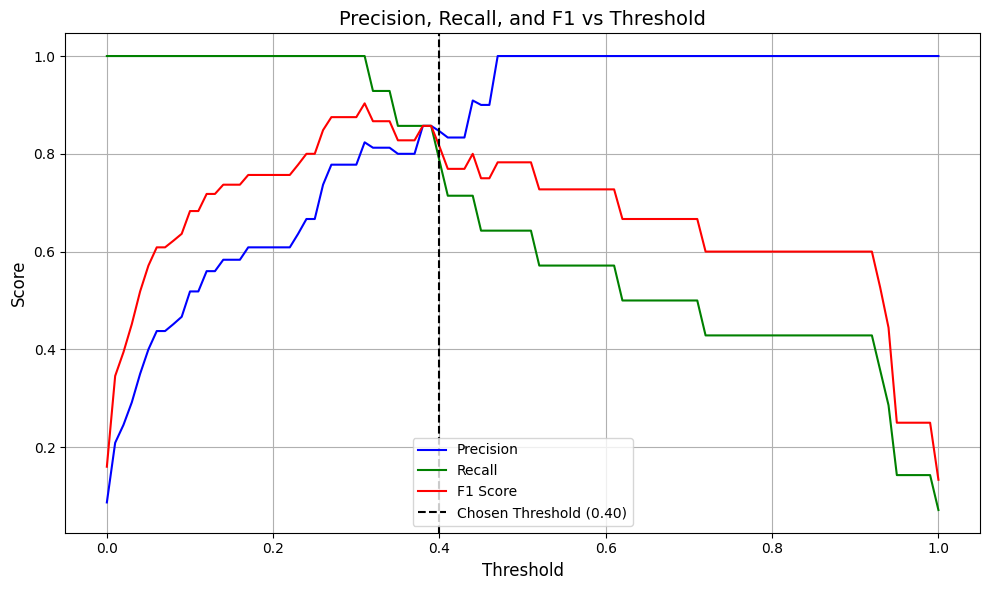

In [ ]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_proba_rf >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_thresh))
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
plt.axvline(x = 0.40, color='black', linestyle='--', label='Chosen Threshold (0.40)')
plt.title("Precision, Recall, and F1 vs Threshold", fontsize=14)
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Optimal Threshold for Highest F1 Score: {best_threshold}")
print(f"Highest F1 Score: {best_f1}")
print(f"Precision: {precision_scores[best_idx]}, Recall: {recall_scores[best_idx]}")

Optimal Threshold for Highest F1 Score: 0.31
Highest F1 Score: 0.9032258064516129
Precision: 0.8235294117647058, Recall: 1.0


Optimal Threshold for Highest F1 Score: 0.31

Highest F1 Score: 0.9032258064516129

Precision: 0.8235294117647058, Recall: 1.0

#### GridSearchCV

In [151]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']  # keep fixed
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='f1',  # optimize for F1!
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

In [ ]:
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

best_rf_proba = best_rf.predict_proba(X_test_scaled)[:, 1]
y_pred_best_thresh = (best_rf_proba >= 0.31).astype(int)

print("\n Classification Report (Best RF @ 0.31 threshold):")
print(classification_report(y_test, y_pred_best_thresh))

print("ROC AUC Score:", roc_auc_score(y_test, best_rf_proba))

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🔍 Classification Report (Best RF @ 0.31 threshold):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.87      0.93      0.90        14

    accuracy                           0.98       161
   macro avg       0.93      0.96      0.94       161
weighted avg       0.98      0.98      0.98       161

ROC AUC Score: 0.9987852283770652


##### Note:
My model was previously overfitting. Every time the model predicted "Legendary", it was correct, But, it only caught half of the actual Legendary Pokémon. So,this meant there was data leakage or we didn't have enough test data.

I removed two features 'base_total' and 'capture_rate'

recall was previously 0.50

#### Random Forest Cross-validation

In [120]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)
scores = cross_val_score(rf, X_train_smote, y_train_smote, cv = cv, scoring = 'roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())

Cross-validated AUC scores: [1.         0.99068595 0.99810066 0.99966844 0.99992632]
Mean AUC: 0.9976762741793687


             Feature  Importance
3  experience_growth    0.309532
5          sp_attack    0.183400
6         sp_defense    0.122723
4                 hp    0.094445
1     base_happiness    0.084097
2            defense    0.078958
0             attack    0.063431
7              speed    0.063414


C:\Users\andre\AppData\Local\Temp\ipykernel_27184\42329510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='Blues_d')


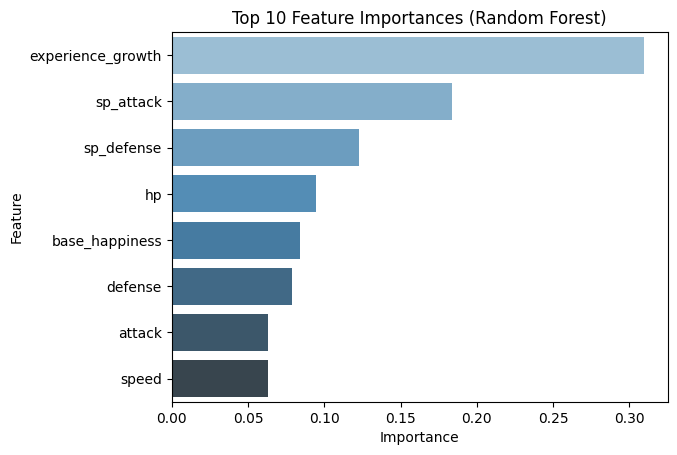

In [129]:
importances = rf.feature_importances_
features = X_train.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

print(feat_df.head(10))

sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='Blues_d')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


#### Tuning Decision Threshold

In [127]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

custom_threshold = 0.4
y_pred_custom = (y_proba_rf >= custom_threshold).astype(int)

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       147
           1       0.85      0.79      0.81        14

    accuracy                           0.97       161
   macro avg       0.91      0.89      0.90       161
weighted avg       0.97      0.97      0.97       161



##### Note:
It appears recall improved at the cost of precision. Here we increased model sensitivity to the minority class (legendaries). Though it costed us precision, our precision is still good.

#### Random Forest Confusion Matrix

#### Training a XGBoost Model

In [ ]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 1234)
xgb_model.fit(X_train_smote, y_train_smote)

xgb_preds = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]


print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_proba))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.90      0.64      0.75        14

    accuracy                           0.96       161
   macro avg       0.93      0.82      0.86       161
weighted avg       0.96      0.96      0.96       161

ROC AUC Score: 0.9941690962099126


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [07:06:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Tuning XGBoost Hyperparameters

In [ ]:
xgb_pred_thresh = (xgb_proba >= 0.31).astype(int)
print("XGBoost Classification Report @ 0.31 Threshold:")
print(classification_report(y_test, xgb_pred_thresh))
print("ROC AUC:", roc_auc_score(y_test, xgb_proba))

🔍 XGBoost Classification Report @ 0.31 Threshold:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.91      0.71      0.80        14

    accuracy                           0.97       161
   macro avg       0.94      0.85      0.89       161
weighted avg       0.97      0.97      0.97       161

ROC AUC: 0.9941690962099126


In [155]:
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 5, 7, 10],
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 5),
    'scale_pos_weight': [1, 3, 5],  # useful for imbalanced data
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

xgb_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [08:43:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020EB2EB6260>,
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020EBA1C9000>,
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020EBA1CA800>},
                   scoring='f1', verbose=2)

In [156]:
best_xgb = xgb_search.best_estimator_
xgb_proba = best_xgb.predict_proba(X_test_scaled)[:, 1]
xgb_thresh_preds = (xgb_proba >= 0.31).astype(int)

print("Tuned XGBoost Report @ 0.31 Threshold")
print(classification_report(y_test, xgb_thresh_preds))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_proba))

Tuned XGBoost Report @ 0.31 Threshold
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       147
           1       1.00      0.79      0.88        14

    accuracy                           0.98       161
   macro avg       0.99      0.89      0.93       161
weighted avg       0.98      0.98      0.98       161

ROC AUC Score: 0.9961127308066083


---

## Conclusion

- The best performing model was XGBoost tuned using RandomizedSearchCV.
- By adjusting the decision threshold to 0.31, recall improved without sacrificing much precision.
- Important features included: `hp`, `attack`, `experience_growth`, and `speed`.

---

## Future Improvements

- Include SHAP values for model interpretability.
- Test the model on newer Pokémon generations.
- Try deep learning approaches or ensemble stacking.
